# Explore PACE and $S_{\rm exp}$

In [17]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23
from oceancolor.utils import plotting as oc_plotting

from big.models import anw as big_anw
from big.models import bbnw as big_bbnw
from big import inference as big_inf
from big import rt as big_rt
from big import chisq_fit

import anly_utils

In [2]:
%matplotlib ipympl

# Load

## L23

In [3]:
ds = loisel23.load_ds(4,0)

### Unpack

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data
adg = ds.ag.data + ds.ad.data
aph = ds.aph.data
anw = ds.anw.data

## Fits

In [5]:
ks = [3,4,5]
pdict = {}
for k in ks:
    pdict[k] = {}
    # Model names
    if k == 3:
        model_names = ['Exp', 'Cst']
    elif k == 4:
        model_names = ['Exp', 'Pow']
    elif k == 5:
        model_names = ['ExpBricaud', 'Pow']
    else:
        raise ValueError("Bad k")

    chain_file, noises, noise_lbl = anly_utils.get_chain_file(
        model_names, 0.02, False, 'L23', use_LM=True,
        PACE=True)
    # Load up
    d = np.load(chain_file)
    # Parse
    pdict[k]['params'] = d['ans']
    if k == ks[0]:
        pdict['Rrs'] = d['obs_Rrs']
        pdict['idx'] = d['idx']
    #import pdb; pdb.set_trace()

In [6]:
pdict[4]['params'].shape

(3320, 4)

# Calc ICs

In [8]:
s2ns = [0.05, 0.10, 0.2, 'PACE']

Adict, Bdict = anly_utils.calc_ICs(
    ks, s2ns, use_LM=True, PACE=True)

Loaded: ../Analysis/Fits/BIG_LM_ExpCst_P23_n02.npz
Loaded: ../Analysis/Fits/BIG_LM_ExpPow_P23_n02.npz
Loaded: ../Analysis/Fits/BIG_LM_ExpBricaudPow_P23_n02.npz


In [9]:
Bdict[4].shape

(4, 3320)

# Fit $a_{\rm dg}$

## Function

In [15]:
def exp_func(wave, A, S, pivot=440.):
    return A * np.exp(-S*(wave-pivot))

## Fit

In [20]:
p0 = [0.2, 0.015]
adg_fits = []
cut = (l23_wave > 400.) & (l23_wave < 525.)
for iadg in adg:
    ans, cov =  curve_fit(exp_func, l23_wave[cut], 
                          iadg[cut],
                          p0=p0, #sigma=np.sqrt(varRrs),
                          full_output=False)
    # 
    adg_fits.append(ans)
adg_fits = np.array(adg_fits)
adg_fits.shape

(3320, 2)

# Plots

## $S_{\rm dg}$

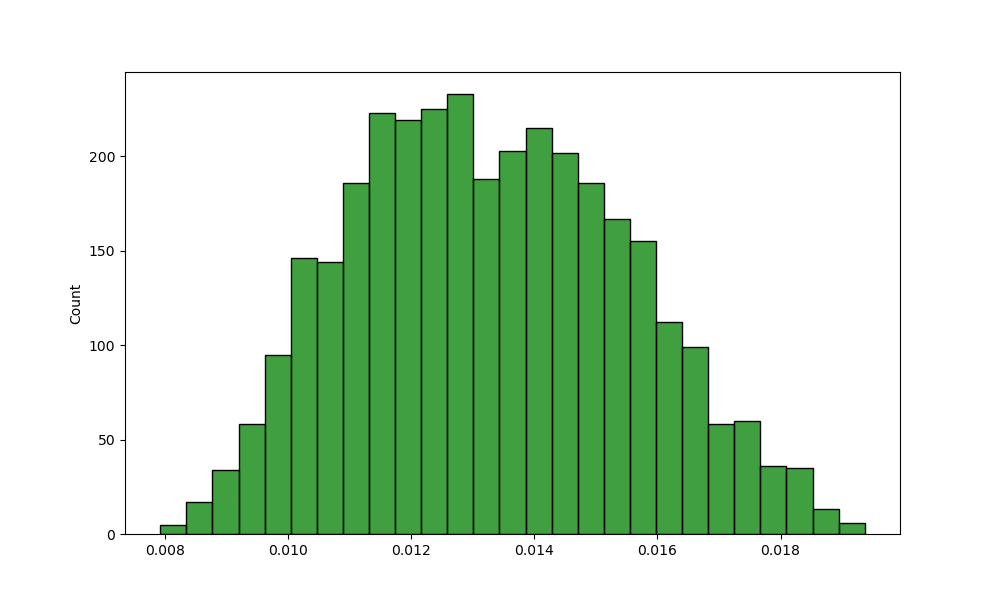

In [21]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
#
sns.histplot(x=adg_fits[:,1], ax=ax, color='green')
#
plt.show()

## $S_{\rm exp}$ vs. $a_{\rm ph}/a$

In [10]:
Sexp = pdict[4]['params'][:,1]

In [11]:
i440 = np.argmin(np.abs(l23_wave-440.))
aph_anw = aph[:,i440]/anw[:,i440]

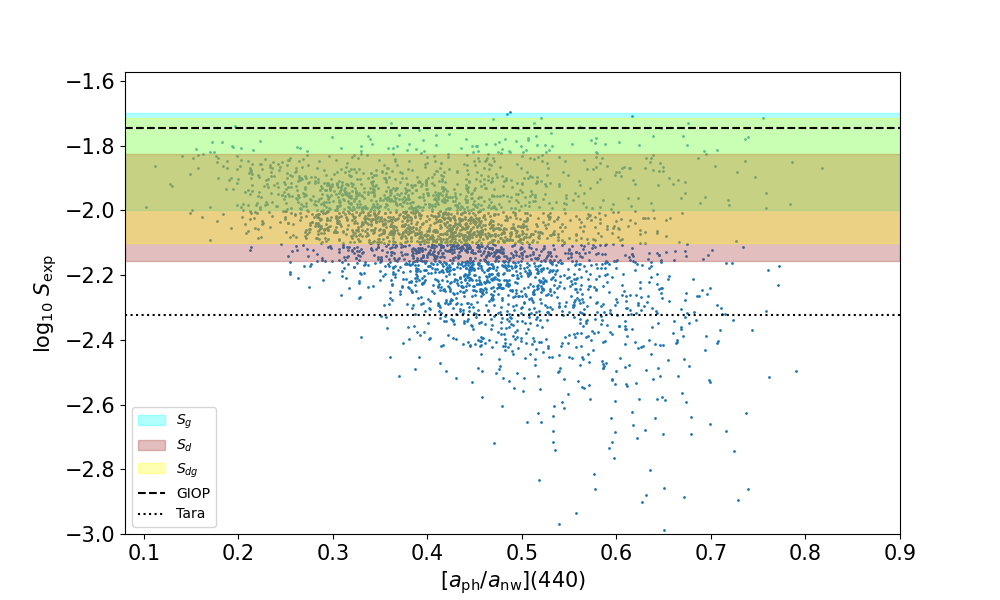

In [25]:
xmin, xmax = 0.08, 0.9
#
cut = Sexp > -6.
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
#
ax.scatter(aph_anw[cut], Sexp[cut], s=1)
# Sg
ax.fill_between([xmin, xmax], [np.log10(0.01)]*2, [np.log10(0.02)]*2, color='cyan', alpha=0.3, label=r'$S_g$')
# Sd
ax.fill_between([xmin, xmax], [np.log10(0.007)]*2, [np.log10(0.015)]*2, color='brown', alpha=0.3, label=r'$S_d$')
# Fit to a_dg
ax.fill_between([xmin, xmax], [np.log10(adg_fits[:,1].min())]*2, [np.log10(adg_fits[:,1].max())]*2, color='yellow', alpha=0.3, label=r'$S_{dg}$')
# Werdell2013
ax.axhline(np.log10(0.018), color='k', ls='--', label='GIOP')
# Tara extreme
ax.axhline(np.log10(0.004746), color='k', ls=':', label='Tara')
#
ax.set_ylabel(r'$\log_{10} \, S_{\rm exp}$')
ax.set_xlabel(r'$[a_{\rm ph}/a_{\rm nw}] (440)$')
ax.set_xlim(xmin, xmax)
#
ax.set_ylim(-3., None)
ax.legend()
#
oc_plotting.set_fontsize(ax, 15.)
plt.show()